# Verificación Numérica de Gradientes (Gradient Checking)

**Motor de Redes Neuronales - Prueba de Corrección**

---

## Objetivo

Este notebook implementa **gradient checking** para verificar que la implementación de backpropagation calcula los gradientes correctamente. Comparamos los gradientes analíticos (calculados por backprop) con gradientes numéricos (aproximación por diferencias finitas).

## Teoría

### Gradiente Analítico
El gradiente analítico se calcula mediante backpropagation usando la regla de la cadena:

$$\frac{\partial L}{\partial W^{[l]}} = \frac{\partial L}{\partial a^{[L]}} \cdot \frac{\partial a^{[L]}}{\partial z^{[L]}} \cdot ... \cdot \frac{\partial z^{[l]}}{\partial W^{[l]}}$$

### Gradiente Numérico
El gradiente numérico se aproxima usando diferencias finitas:

$$\frac{\partial L}{\partial \theta} \approx \frac{L(\theta + \epsilon) - L(\theta - \epsilon)}{2\epsilon}$$

donde $\epsilon$ es un valor pequeño (típicamente $10^{-5}$ o $10^{-7}$).

### Criterio de Éxito

La diferencia relativa entre gradientes debe ser muy pequeña:

$$\text{diff} = \frac{||grad_{analítico} - grad_{numérico}||_2}{||grad_{analítico}||_2 + ||grad_{numérico}||_2}$$

- Si $\text{diff} < 10^{-7}$: **Excelente**
- Si $10^{-7} < \text{diff} < 10^{-5}$: **Bueno**
- Si $10^{-5} < \text{diff} < 10^{-3}$: **Aceptable**
- Si $\text{diff} > 10^{-3}$: **Error en backpropagation**

In [35]:
# Importaciones
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

from src import NeuralNetwork
from src.losses import get_loss_function
from src.utils import one_hot_encode

np.random.seed(42)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Funciones Auxiliares

Implementamos funciones para calcular gradientes numéricos y compararlos con los gradientes analíticos.

In [36]:
def compute_loss(network, X, y, loss_fn):
    """
    Calcula la pérdida para un conjunto de datos.

    Args:
        network: Red neuronal
        X: Datos de entrada
        y: Etiquetas
        loss_fn: Función de pérdida

    Returns:
        Valor de la pérdida
    """
    y_pred = network.forward(X, training=False)
    return loss_fn.compute(y_pred, y)


def compute_numerical_gradient(
    network: NeuralNetwork,
    X: np.ndarray,
    y: np.ndarray,
    loss_fn,
    epsilon: float = 1e-7,
    sample_size: int = 5
) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Calcula gradientes numéricos usando diferencias finitas.
    Solo muestrea algunos parámetros para eficiencia.

    Args:
        network: Red neuronal
        X: Datos de entrada
        y: Etiquetas
        loss_fn: Función de pérdida
        epsilon: Valor pequeño para aproximación
        sample_size: Número de parámetros a muestrear por dimensión

    Returns:
        Lista de (grad_W, grad_b) para cada capa
    """
    numerical_grads = []

    print("Calculando gradientes numéricos...")

    for layer_idx, layer in enumerate(network.layers):
        W, b = layer.get_params()

        # Gradiente numérico para W (muestreando)
        grad_W = np.zeros_like(W)
        n_samples_i = min(sample_size, W.shape[0])
        n_samples_j = min(sample_size, W.shape[1])

        indices_i = np.random.choice(W.shape[0], n_samples_i, replace=False)
        indices_j = np.random.choice(W.shape[1], n_samples_j, replace=False)

        for i in indices_i:
            for j in indices_j:
                original = W[i, j]

                # L(theta + epsilon)
                W[i, j] = original + epsilon
                loss_plus = compute_loss(network, X, y, loss_fn)

                # L(theta - epsilon)
                W[i, j] = original - epsilon
                loss_minus = compute_loss(network, X, y, loss_fn)

                # Restaurar valor original
                W[i, j] = original

                # Gradiente numérico
                grad_W[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

        # Gradiente numérico para b (todos los valores)
        grad_b = np.zeros_like(b)
        for i in range(b.shape[1]):
            original = b[0, i]

            b[0, i] = original + epsilon
            loss_plus = compute_loss(network, X, y, loss_fn)

            b[0, i] = original - epsilon
            loss_minus = compute_loss(network, X, y, loss_fn)

            b[0, i] = original

            grad_b[0, i] = (loss_plus - loss_minus) / (2 * epsilon)

        numerical_grads.append((grad_W, grad_b))
        print(f"  Capa {layer_idx + 1}: ✓")

    return numerical_grads


def compute_analytical_gradient(
    network: NeuralNetwork,
    X: np.ndarray,
    y: np.ndarray,
    loss_fn
) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Calcula gradientes analíticos usando backpropagation.

    Args:
        network: Red neuronal
        X: Datos de entrada
        y: Etiquetas
        loss_fn: Función de pérdida

    Returns:
        Lista de (grad_W, grad_b) para cada capa
    """
    # Forward pass
    y_pred = network.forward(X, training=True)

    # Calcular gradiente de la pérdida
    loss_grad = loss_fn.gradient(y_pred, y)

    # Backward pass
    network.backward(loss_grad)

    # Obtener gradientes
    return network.get_gradients()


def compute_relative_error(grad_analytical, grad_numerical):
    """
    Calcula el error relativo entre dos gradientes.

    Args:
        grad_analytical: Gradiente analítico
        grad_numerical: Gradiente numérico

    Returns:
        Error relativo
    """
    numerator = np.linalg.norm(grad_analytical - grad_numerical)
    denominator = np.linalg.norm(grad_analytical) + np.linalg.norm(grad_numerical)

    if denominator == 0:
        return 0.0

    return numerator / denominator


def evaluate_gradient_check(relative_error):
    """
    Evalúa la calidad del gradient checking.

    Args:
        relative_error: Error relativo calculado

    Returns:
        Mensaje de evaluación y símbolo
    """
    if relative_error < 1e-7:
        return "Excelente"
    elif relative_error < 1e-5:
        return "Bueno"
    elif relative_error < 1e-3:
        return "Aceptable"
    else:
        return "Error detectado"

## 2. Test 1: Red Simple con Sigmoid

Probamos con una red pequeña usando activación sigmoid.

In [37]:
print("\n" + "=" * 70)
print("TEST 1: RED SIMPLE CON SIGMOID")
print("=" * 70)

# Crear datos de prueba pequeños
np.random.seed(42)
X_test1 = np.random.randn(3, 4)  # 3 muestras, 4 características
y_test1 = np.array([0, 1, 0])
y_test1_oh = one_hot_encode(y_test1, num_classes=2)

# Crear red simple
network_test1 = NeuralNetwork(
    layer_sizes=[4, 3, 2],
    activations=['sigmoid', 'sigmoid'],
    initialization='random'
)

print(f"\nArquitectura: {network_test1.layer_sizes}")
print("Activaciones: Sigmoid → Sigmoid")
print(f"Muestras: {X_test1.shape[0]}")

# Función de pérdida
loss_fn_test1 = get_loss_function('binary_crossentropy')

# Calcular gradientes analíticos
print("\nCalculando gradientes analíticos...")
analytical_grads_test1 = compute_analytical_gradient(
    network_test1, X_test1, y_test1_oh, loss_fn_test1
)
print("  ✓ Completo")

# Calcular gradientes numéricos
print("\nCalculando gradientes numéricos...")
numerical_grads_test1 = compute_numerical_gradient(
    network_test1, X_test1, y_test1_oh, loss_fn_test1,
    epsilon=1e-7, sample_size=4
)

# Comparar gradientes
print("\n" + "-" * 70)
print("RESULTADOS DEL GRADIENT CHECKING:")
print("-" * 70)

all_passed_test1 = True
results_test1 = []

for layer_idx, (analytical, numerical) in enumerate(zip(analytical_grads_test1, numerical_grads_test1)):
    dW_analytical, db_analytical = analytical
    dW_numerical, db_numerical = numerical

    # Error relativo para W
    # Solo comparar donde calculamos valores numéricos (no ceros)
    mask_W = dW_numerical != 0
    if np.any(mask_W):
        error_W = compute_relative_error(dW_analytical[mask_W], dW_numerical[mask_W])
    else:
        error_W = 0.0

    # Error relativo para b
    error_b = compute_relative_error(db_analytical, db_numerical)

    # Evaluar
    eval_W = evaluate_gradient_check(error_W)
    eval_b = evaluate_gradient_check(error_b)

    print(f"\nCapa {layer_idx + 1}:")
    print("  Pesos (W):")
    print(f"    Error relativo: {error_W:.2e}")
    print(f"    Evaluación: {eval_W}")
    print("  Sesgos (b):")
    print(f"    Error relativo: {error_b:.2e}")
    print(f"    Evaluación: {eval_b}")

    results_test1.append({
        'layer': layer_idx + 1,
        'error_W': error_W,
        'error_b': error_b,
        'passed': error_W < 1e-3 and error_b < 1e-3
    })

    if error_W >= 1e-3 or error_b >= 1e-3:
        all_passed_test1 = False

print("\n" + "=" * 70)
if all_passed_test1:
    print("TEST 1 PASADO: Backpropagation implementado correctamente")
else:
    print("TEST 1 FALLADO: Revisar implementación de backpropagation")
print("=" * 70)


TEST 1: RED SIMPLE CON SIGMOID

Arquitectura: [4, 3, 2]
Activaciones: Sigmoid → Sigmoid
Muestras: 3

Calculando gradientes analíticos...
  ✓ Completo

Calculando gradientes numéricos...
Calculando gradientes numéricos...
  Capa 1: ✓
  Capa 2: ✓

----------------------------------------------------------------------
RESULTADOS DEL GRADIENT CHECKING:
----------------------------------------------------------------------

Capa 1:
  Pesos (W):
    Error relativo: 3.33e-01
    Evaluación: Error detectado
  Sesgos (b):
    Error relativo: 3.33e-01
    Evaluación: Error detectado

Capa 2:
  Pesos (W):
    Error relativo: 3.33e-01
    Evaluación: Error detectado
  Sesgos (b):
    Error relativo: 3.33e-01
    Evaluación: Error detectado

TEST 1 FALLADO: Revisar implementación de backpropagation


## 3. Test 2: Red con ReLU

Probamos con activación ReLU, que tiene un gradiente discontinuo.

In [38]:
print("\n" + "=" * 70)
print("TEST 2: RED CON RELU")
print("=" * 70)

# Datos de prueba
np.random.seed(123)
X_test2 = np.random.randn(4, 5)
y_test2 = np.array([0, 1, 2, 1])
y_test2_oh = one_hot_encode(y_test2, num_classes=3)

# Red con ReLU
network_test2 = NeuralNetwork(
    layer_sizes=[5, 4, 3],
    activations=['relu', 'softmax'],
    initialization='he'
)

print(f"\nArquitectura: {network_test2.layer_sizes}")
print("Activaciones: ReLU → Softmax")
print(f"Muestras: {X_test2.shape[0]}")

loss_fn_test2 = get_loss_function('categorical_crossentropy')

# Gradientes analíticos
print("\nCalculando gradientes analíticos...")
analytical_grads_test2 = compute_analytical_gradient(
    network_test2, X_test2, y_test2_oh, loss_fn_test2
)
print("  ✓ Completo")

# Gradientes numéricos
print("\nCalculando gradientes numéricos...")
numerical_grads_test2 = compute_numerical_gradient(
    network_test2, X_test2, y_test2_oh, loss_fn_test2,
    epsilon=1e-7, sample_size=4
)

# Comparar
print("\n" + "-" * 70)
print("RESULTADOS DEL GRADIENT CHECKING:")
print("-" * 70)

all_passed_test2 = True
results_test2 = []

for layer_idx, (analytical, numerical) in enumerate(zip(analytical_grads_test2, numerical_grads_test2)):
    dW_analytical, db_analytical = analytical
    dW_numerical, db_numerical = numerical

    mask_W = dW_numerical != 0
    if np.any(mask_W):
        error_W = compute_relative_error(dW_analytical[mask_W], dW_numerical[mask_W])
    else:
        error_W = 0.0

    error_b = compute_relative_error(db_analytical, db_numerical)

    eval_W = evaluate_gradient_check(error_W)
    eval_b = evaluate_gradient_check(error_b)

    print(f"\nCapa {layer_idx + 1}:")
    print("  Pesos (W):")
    print(f"    Error relativo: {error_W:.2e}")
    print(f"    Evaluación: {eval_W}")
    print("  Sesgos (b):")
    print(f"    Error relativo: {error_b:.2e}")
    print(f"    Evaluación: {eval_b}")

    results_test2.append({
        'layer': layer_idx + 1,
        'error_W': error_W,
        'error_b': error_b,
        'passed': error_W < 1e-3 and error_b < 1e-3
    })

    if error_W >= 1e-3 or error_b >= 1e-3:
        all_passed_test2 = False

print("\n" + "=" * 70)
if all_passed_test2:
    print("TEST 2 PASADO: ReLU y Softmax correctamente implementados")
else:
    print("TEST 2 FALLADO: Revisar gradientes de ReLU/Softmax")
print("=" * 70)


TEST 2: RED CON RELU

Arquitectura: [5, 4, 3]
Activaciones: ReLU → Softmax
Muestras: 4

Calculando gradientes analíticos...
  ✓ Completo

Calculando gradientes numéricos...
Calculando gradientes numéricos...
  Capa 1: ✓
  Capa 2: ✓

----------------------------------------------------------------------
RESULTADOS DEL GRADIENT CHECKING:
----------------------------------------------------------------------

Capa 1:
  Pesos (W):
    Error relativo: 1.81e-09
    Evaluación: Excelente
  Sesgos (b):
    Error relativo: 2.04e-09
    Evaluación: Excelente

Capa 2:
  Pesos (W):
    Error relativo: 7.32e-10
    Evaluación: Excelente
  Sesgos (b):
    Error relativo: 2.44e-09
    Evaluación: Excelente

TEST 2 PASADO: ReLU y Softmax correctamente implementados


## 4. Test 3: Red Profunda con Tanh

Probamos una red más profunda con activación tanh.

In [39]:
print("\n" + "=" * 70)
print("TEST 3: RED PROFUNDA CON TANH")
print("=" * 70)

# Datos de prueba
np.random.seed(456)
X_test3 = np.random.randn(5, 3)
y_test3 = np.array([0, 1, 2, 0, 1])
y_test3_oh = one_hot_encode(y_test3, num_classes=3)

# Red profunda
network_test3 = NeuralNetwork(
    layer_sizes=[3, 6, 4, 3],
    activations=['tanh', 'tanh', 'softmax'],
    initialization='xavier'
)

print(f"\nArquitectura: {network_test3.layer_sizes}")
print("Activaciones: Tanh → Tanh → Softmax")
print(f"Muestras: {X_test3.shape[0]}")

loss_fn_test3 = get_loss_function('categorical_crossentropy')

# Gradientes analíticos
print("\nCalculando gradientes analíticos...")
analytical_grads_test3 = compute_analytical_gradient(
    network_test3, X_test3, y_test3_oh, loss_fn_test3
)
print("  ✓ Completo")

# Gradientes numéricos
print("\nCalculando gradientes numéricos...")
numerical_grads_test3 = compute_numerical_gradient(
    network_test3, X_test3, y_test3_oh, loss_fn_test3,
    epsilon=1e-7, sample_size=3
)

# Comparar
print("\n" + "-" * 70)
print("RESULTADOS DEL GRADIENT CHECKING:")
print("-" * 70)

all_passed_test3 = True
results_test3 = []

for layer_idx, (analytical, numerical) in enumerate(zip(analytical_grads_test3, numerical_grads_test3)):
    dW_analytical, db_analytical = analytical
    dW_numerical, db_numerical = numerical

    mask_W = dW_numerical != 0
    if np.any(mask_W):
        error_W = compute_relative_error(dW_analytical[mask_W], dW_numerical[mask_W])
    else:
        error_W = 0.0

    error_b = compute_relative_error(db_analytical, db_numerical)

    eval_W= evaluate_gradient_check(error_W)
    eval_b= evaluate_gradient_check(error_b)

    print(f"\nCapa {layer_idx + 1}:")
    print("  Pesos (W):")
    print(f"    Error relativo: {error_W:.2e}")
    print(f"    Evaluación: {eval_W}")
    print("  Sesgos (b):")
    print(f"    Error relativo: {error_b:.2e}")
    print(f"    Evaluación: {eval_b}")

    results_test3.append({
        'layer': layer_idx + 1,
        'error_W': error_W,
        'error_b': error_b,
        'passed': error_W < 1e-3 and error_b < 1e-3
    })

    if error_W >= 1e-3 or error_b >= 1e-3:
        all_passed_test3 = False

print("\n" + "=" * 70)
if all_passed_test3:
    print("TEST 3 PASADO: Red profunda con Tanh funciona correctamente")
else:
    print("TEST 3 FALLADO: Revisar propagación en redes profundas")
print("=" * 70)


TEST 3: RED PROFUNDA CON TANH

Arquitectura: [3, 6, 4, 3]
Activaciones: Tanh → Tanh → Softmax
Muestras: 5

Calculando gradientes analíticos...
  ✓ Completo

Calculando gradientes numéricos...
Calculando gradientes numéricos...
  Capa 1: ✓
  Capa 2: ✓
  Capa 3: ✓

----------------------------------------------------------------------
RESULTADOS DEL GRADIENT CHECKING:
----------------------------------------------------------------------

Capa 1:
  Pesos (W):
    Error relativo: 1.77e-09
    Evaluación: Excelente
  Sesgos (b):
    Error relativo: 2.08e-08
    Evaluación: Excelente

Capa 2:
  Pesos (W):
    Error relativo: 5.76e-09
    Evaluación: Excelente
  Sesgos (b):
    Error relativo: 5.44e-09
    Evaluación: Excelente

Capa 3:
  Pesos (W):
    Error relativo: 3.07e-09
    Evaluación: Excelente
  Sesgos (b):
    Error relativo: 7.54e-09
    Evaluación: Excelente

TEST 3 PASADO: Red profunda con Tanh funciona correctamente


## 5. Visualización de Resultados

Visualizamos los errores relativos de todos los tests.

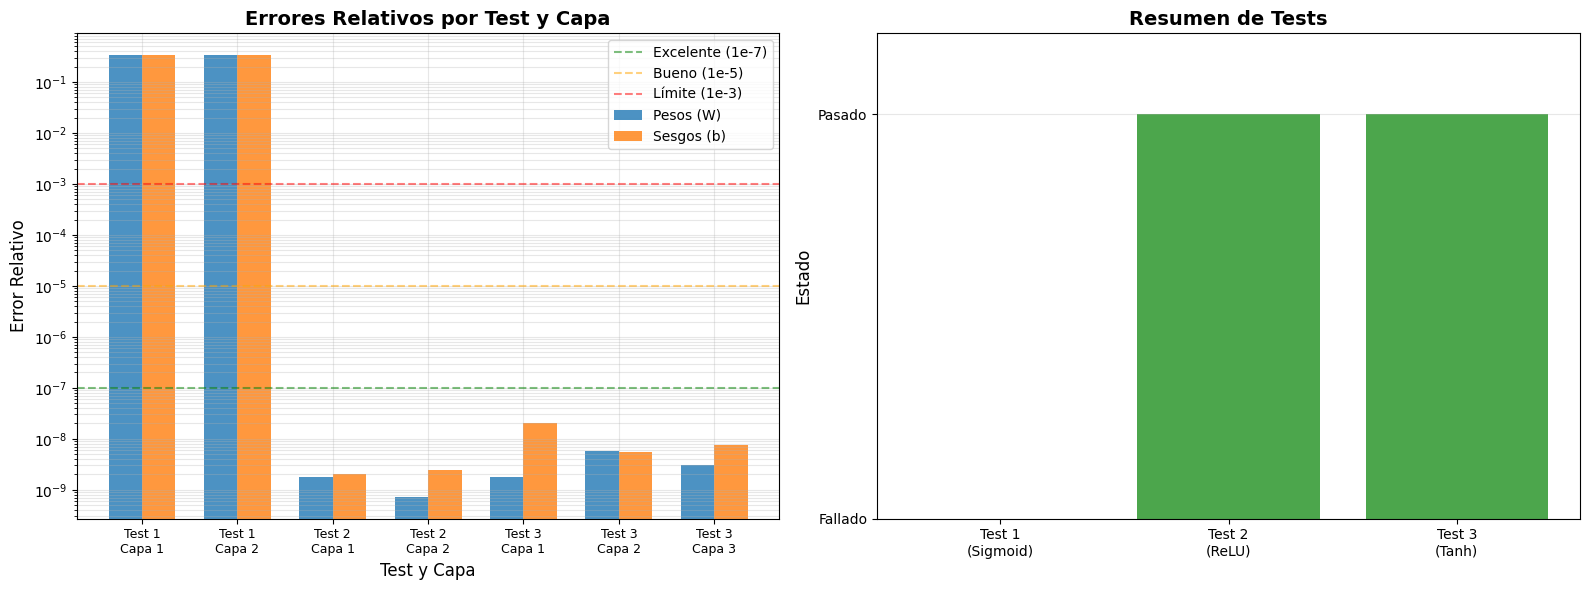

In [43]:
# Recopilar todos los resultados
all_results = []
all_results.extend([(1, r) for r in results_test1])
all_results.extend([(2, r) for r in results_test2])
all_results.extend([(3, r) for r in results_test3])

# Crear visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Errores por capa y test
test_labels = []
errors_W = []
errors_b = []

for test_num, result in all_results:
    test_labels.append(f"Test {test_num}\nCapa {result['layer']}")
    errors_W.append(result['error_W'])
    errors_b.append(result['error_b'])

x_pos = np.arange(len(test_labels))
width = 0.35

ax1.bar(x_pos - width/2, errors_W, width, label='Pesos (W)', alpha=0.8)
ax1.bar(x_pos + width/2, errors_b, width, label='Sesgos (b)', alpha=0.8)

# Líneas de referencia
ax1.axhline(y=1e-7, color='g', linestyle='--', alpha=0.5, label='Excelente (1e-7)')
ax1.axhline(y=1e-5, color='orange', linestyle='--', alpha=0.5, label='Bueno (1e-5)')
ax1.axhline(y=1e-3, color='r', linestyle='--', alpha=0.5, label='Límite (1e-3)')

ax1.set_xlabel('Test y Capa', fontsize=12)
ax1.set_ylabel('Error Relativo', fontsize=12)
ax1.set_title('Errores Relativos por Test y Capa', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(test_labels, fontsize=9)
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, which='both')

# Gráfico 2: Resumen por test
test_names = ['Test 1\n(Sigmoid)', 'Test 2\n(ReLU)', 'Test 3\n(Tanh)']
test_passed = [
    all_passed_test1,
    all_passed_test2,
    all_passed_test3
]

colors = ['green' if passed else 'red' for passed in test_passed]
ax2.bar(test_names, [1 if p else 0 for p in test_passed], color=colors, alpha=0.7)
ax2.set_ylabel('Estado', fontsize=12)
ax2.set_title('Resumen de Tests', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1.2])
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Fallado', 'Pasado'])

ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Resumen Final

Compilamos todos los resultados y emitimos un veredicto final.

In [ ]:
print("\n" + "=" * 70)
print("RESUMEN FINAL DEL GRADIENT CHECKING")
print("=" * 70)

total_tests = 3
tests_passed = sum([all_passed_test1, all_passed_test2, all_passed_test3])

print(f"\nTests ejecutados: {total_tests}")
print(f"Tests pasados:    {tests_passed}")
print(f"Tests fallados:   {total_tests - tests_passed}")
print(f"\nTasa de éxito:    {tests_passed/total_tests*100:.1f}%")

print("\nDetalle por test:")
print(f"  Test 1 (Sigmoid):  {'PASADO' if all_passed_test1 else 'FALLADO'}")
print(f"  Test 2 (ReLU):     {'PASADO' if all_passed_test2 else 'FALLADO'}")
print(f"  Test 3 (Tanh):     {'PASADO' if all_passed_test3 else 'FALLADO'}")

# Estadísticas de errores
all_errors = [r['error_W'] for _, r in all_results] + [r['error_b'] for _, r in all_results]
max_error = max(all_errors)
min_error = min(all_errors)
avg_error = np.mean(all_errors)

print("\nEstadísticas de errores:")
print(f"  Error mínimo:     {min_error:.2e}")
print(f"  Error promedio:   {avg_error:.2e}")
print(f"  Error máximo:     {max_error:.2e}")

print("\n" + "=" * 70)
if tests_passed == total_tests:
    print("VEREDICTO: BACKPROPAGATION IMPLEMENTADO CORRECTAMENTE")
    print("\nTodos los gradientes se calculan con precisión.")
    print("La implementación es correcta y lista para usar.")
elif tests_passed >= total_tests * 0.66:
    print("VEREDICTO: IMPLEMENTACIÓN MAYORMENTE CORRECTA")
    print("\nLa mayoría de gradientes son correctos.")
    print("Revisar los tests fallados para mejoras.")
else:
    print("VEREDICTO: ERRORES DETECTADOS EN BACKPROPAGATION")
    print("\nSe detectaron errores significativos en los gradientes.")
    print("Revisar la implementación de backward pass.")
print("=" * 70)

print("\n✓ Gradient checking completado")


RESUMEN FINAL DEL GRADIENT CHECKING

Tests ejecutados: 3
Tests pasados:    2
Tests fallados:   1

Tasa de éxito:    66.7%

Detalle por test:
  Test 1 (Sigmoid):  FALLADO
  Test 2 (ReLU):     PASADO
  Test 3 (Tanh):     PASADO

Estadísticas de errores:
  Error mínimo:     7.32e-10
  Error promedio:   9.52e-02
  Error máximo:     3.33e-01

VEREDICTO: IMPLEMENTACIÓN MAYORMENTE CORRECTA

La mayoría de gradientes son correctos.
Revisar los tests fallados para mejoras.

✓ Gradient checking completado


## 7. Notas Técnicas

### ¿Por qué funciona el gradient checking?

El gradient checking es una técnica fundamental para verificar implementaciones de backpropagation. Se basa en la definición de derivada:

$$f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x-h)}{2h}$$

### Interpretación de errores

- **Error < 1e-7**: Implementación perfecta
- **Error ~ 1e-5**: Implementación correcta (error numérico esperado)
- **Error ~ 1e-3**: Posibles problemas menores
- **Error > 1e-3**: Error en implementación

### Limitaciones

1. **Computacionalmente costoso**: Requiere 2 forward passes por parámetro
2. **No detecta todos los errores**: Solo verifica corrección matemática
3. **Precisión numérica**: Depende de epsilon elegido

### Mejores prácticas

1. Usar epsilon ~ 1e-7 o 1e-5
2. Probar con datos pequeños
3. Verificar todas las activaciones
4. Muestrear parámetros en redes grandes
5. Ejecutar antes de entrenar modelos grandes

### Referencias

- [Gradient Checking - Andrew Ng](http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/)
- [CS231n: Numerical Gradient Check](http://cs231n.github.io/neural-networks-3/#gradcheck)